## clustering with `hdbscan`


In [12]:
!pip install hdbscan seaborn altair

  Using cached altair-4.1.0-py3-none-any.whl (727 kB)
You should consider upgrading via the '/Users/kalyan/.pyenv/versions/3.7.9/envs/hcvectors/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
%load_ext autoreload
%autoreload 2

import time

import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

import utils

def paginate_list(l, page_size):
    return (l[i : i + page_size] for i in range(0, len(l), page_size))

ENTITY_LABEL_MAPPING = dict()

In [2]:
# load embeddings matrix using KGEmbeddingStore class
emb_store = utils.load_embedding_store()
X = emb_store.ent_embedding_matrix
dim = X.shape[1]

X.shape

/Users/kalyan/Documents/SMG/heritage-connector-vectors/notebooks/clustering/utils.py:37: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  mappings_file_names=["entities.tsv", "relations.tsv"],


(645565, 800)

In [3]:
# load UMAP projections
umap_projection_path = "../../data/processed/final_model_dglke/umap/best_projection_n_neighbours_10.npy"
umap_data = np.load(umap_projection_path)

umap_data.shape

(645565, 2)

## 1. fit clusterer

TODO: loop through sets of parameters. See [here](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)

In [4]:
MIN_CLUSTER_SIZE = 500

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=MIN_CLUSTER_SIZE,
)

start = time.time()
clusterer.fit(umap_data)
end = time.time()

print(f"completed in {int(end-start)}s")
print(f"there are {len(np.unique(clusterer.labels_))-1} clusters")
print(f"{len(np.where(clusterer.labels_ == -1)[0])} entities are not clustered")

completed in 57s
there are 199 clusters
210533 entities are not clustered


In [5]:
labels = clusterer.labels_
probabilities = clusterer.probabilities_

### 1.1 export clusters to mapping

so we can use them in the interactive visualisation

In [6]:
ents = emb_store.idxs_to_entities(range(emb_store.ent_embedding_matrix.shape[0]))


mapping = pd.DataFrame(list(zip(ents, labels)), columns=["entity", "cluster"])
mapping.to_csv(f"../../data/processed/embedding_colour_mappings/mapping_hdbscan_clusters_min_size_{MIN_CLUSTER_SIZE}.tsv", sep="\t", header=False)

## 2. inspect clusters

### 2.1 cluster size distribution

/Users/kalyan/.pyenv/versions/3.7.9/envs/hcvectors/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'cluster size distribution')

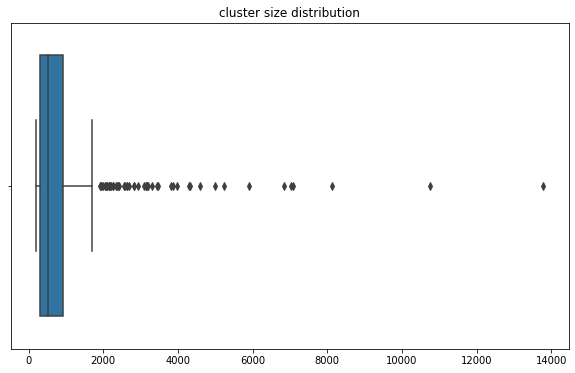

In [7]:
fig, axs = plt.subplots(figsize=(10,6))

labels_clustered = labels[np.where(labels > 0)]
unique, counts = np.unique(labels_clustered, return_counts=True)
sns.boxplot(counts, ax=axs).set_title("cluster size distribution")


### 2.2 inspect clusters manually

In [8]:
PAGE_SIZE = 250
URL_ENDINGS_IGNORE_FOR_LABELLING = [".jpg", ".jpeg", ".png", ".gif", ".svg", ".tif"]

def show_cluster(idx):
    cluster_entities = emb_store.idxs_to_entities(
        np.where(labels == idx)
    )

    cluster_urls = [i for i in cluster_entities if i.startswith("http") 
                                                and not any([i.lower().endswith(ending) for ending in URL_ENDINGS_IGNORE_FOR_LABELLING])
                                                and i not in ENTITY_LABEL_MAPPING.keys()]

    print("Getting labels")
    for page in tqdm(paginate_list(cluster_urls, PAGE_SIZE)):
        ENTITY_LABEL_MAPPING.update(utils.get_labels(page))
        
    cluster_labels = [ENTITY_LABEL_MAPPING.get(ent, "<no label>") for ent in cluster_entities]
    
    print("\n".join([f"{cluster_labels[i]} - {cluster_entities[i]}" for i in range(len(cluster_entities))]))
    
###
    
idx = 100
show_cluster(idx)

Getting labels


0it [00:00, ?it/s]

Letter from Alex Vincent to Patrick Moore - https://collection.sciencemuseumgroup.org.uk/documents/aa110081787
Documents relating to Patrick Moore's Coat of Arms - https://collection.sciencemuseumgroup.org.uk/documents/aa110081771
La Planete Mars, vol 2 - https://collection.sciencemuseumgroup.org.uk/documents/aa110081315
Full-length portrait of a man, marked verso 'Father' - https://collection.sciencemuseumgroup.org.uk/documents/aa110081565
Popular Star Maps - A Rapid and Easy Method of Finding the Principal Stars - https://collection.sciencemuseumgroup.org.uk/documents/aa110081304
Letter from Mat Irvine to Patrick Moore - https://collection.sciencemuseumgroup.org.uk/documents/aa110081778
Digital Photographs - https://collection.sciencemuseumgroup.org.uk/documents/aa110081444
Presentation Photographs - https://collection.sciencemuseumgroup.org.uk/documents/aa110081446
The Stars and how to Identify them - https://collection.sciencemuseumgroup.org.uk/documents/aa110081322
Letter from Sim

## 2.3 Unclustered entities

In [9]:
unclustered_ents = emb_store.idxs_to_entities(np.where(clusterer.labels_ == -1)[0])
unclustered_ents[0:20]

['plastic',
 'https://collection.sciencemuseumgroup.org.uk/people/cp28358',
 'https://collection.sciencemuseumgroup.org.uk/objects/co8372099',
 'https://collection.sciencemuseumgroup.org.uk/objects/co167884',
 'http://www.wikidata.org/entity/Q17555284',
 'https://collection.sciencemuseumgroup.org.uk/objects/co102368',
 'card',
 'http://www.wikidata.org/entity/Q1412684',
 'http://www.wikidata.org/entity/Q55222906',
 'https://collection.sciencemuseumgroup.org.uk/objects/co8420316',
 'Lighting',
 'https://collection.sciencemuseumgroup.org.uk/objects/co189004',
 'jacket',
 'https://collection.sciencemuseumgroup.org.uk/objects/co168091',
 'https://collection.sciencemuseumgroup.org.uk/objects/co8384253',
 'paper',
 'anatomical chart',
 'synthetic fibres',
 'https://collection.sciencemuseumgroup.org.uk/objects/co72474',
 'commemorative medal']

## 3. plot clusters

In [44]:
df = pd.DataFrame(umap_data, columns=["x", "y"])
df['cluster'] = clusterer.labels_
df['probability'] = clusterer.probabilities_
df['entity'] = emb_store.idxs_to_entities(df.index)
df[['entity','cluster']] = df[['entity','cluster']].astype(str)
df.head()

,x,y,cluster,probability,entity
0,4.982193,4.177696,467,0.703985,https://collection.sciencemuseumgroup.org.uk/p...
1,5.086479,4.084801,467,0.606761,http://www.wikidata.org/entity/Q3568968
2,-9.554541,-5.450275,379,1.000000,https://collection.sciencemuseumgroup.org.uk/o...
3,-3.474861,-15.172668,-1,0.000000,plastic
4,2.950962,4.017635,-1,0.000000,https://collection.sciencemuseumgroup.org.uk/p...


In [48]:
ents_to_label = [i for i in df['entity'].tolist() if i.startswith("http") 
                        and not any([i.lower().endswith(ending) for ending in URL_ENDINGS_IGNORE_FOR_LABELLING])
                        and i not in ENTITY_LABEL_MAPPING.keys()]

ent_label_mapping = {}

print("Getting labels")
for page in tqdm(paginate_list(ents_to_label, page_size=250), total=int(len(ents_to_label)/250)+1):
    ent_label_mapping.update(utils.get_labels(page))

Getting labels


  0%|          | 0/1875 [00:00<?, ?it/s]

<Response [502]>


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

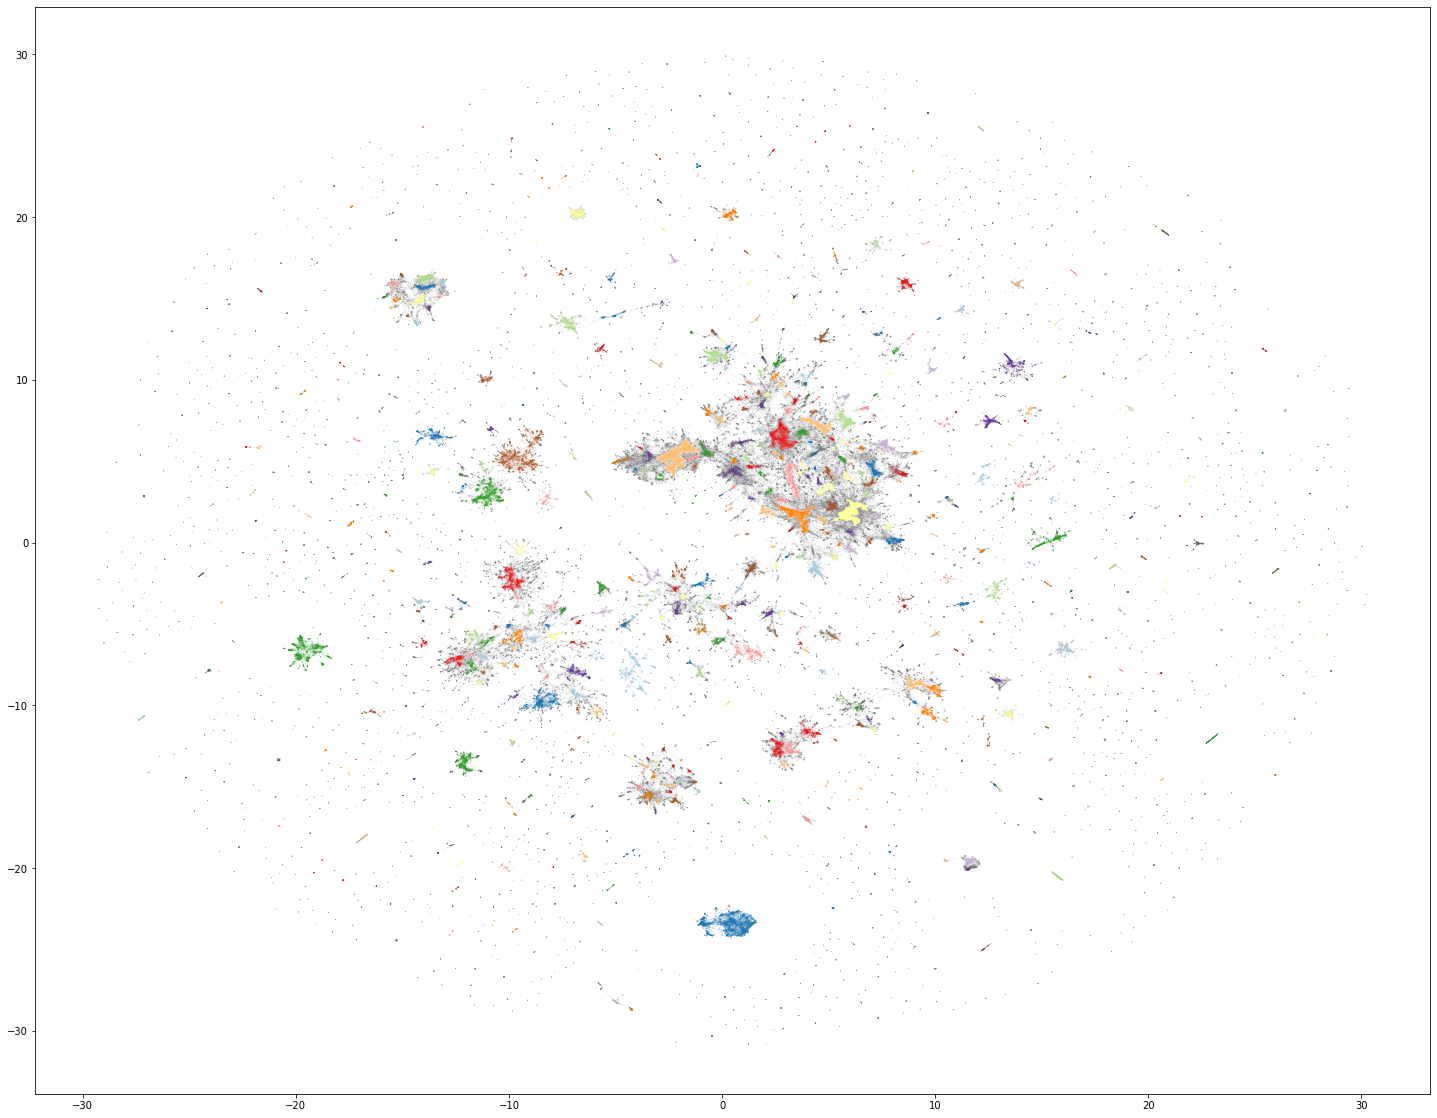

In [10]:
color_palette = sns.color_palette('Paired', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

fig, ax = plt.subplots(figsize=(25,20))
plt.scatter(*umap_data.T, s=0.5, linewidth=0, c=cluster_member_colors, alpha=0.25)

## 3.1 plot a few select clusters

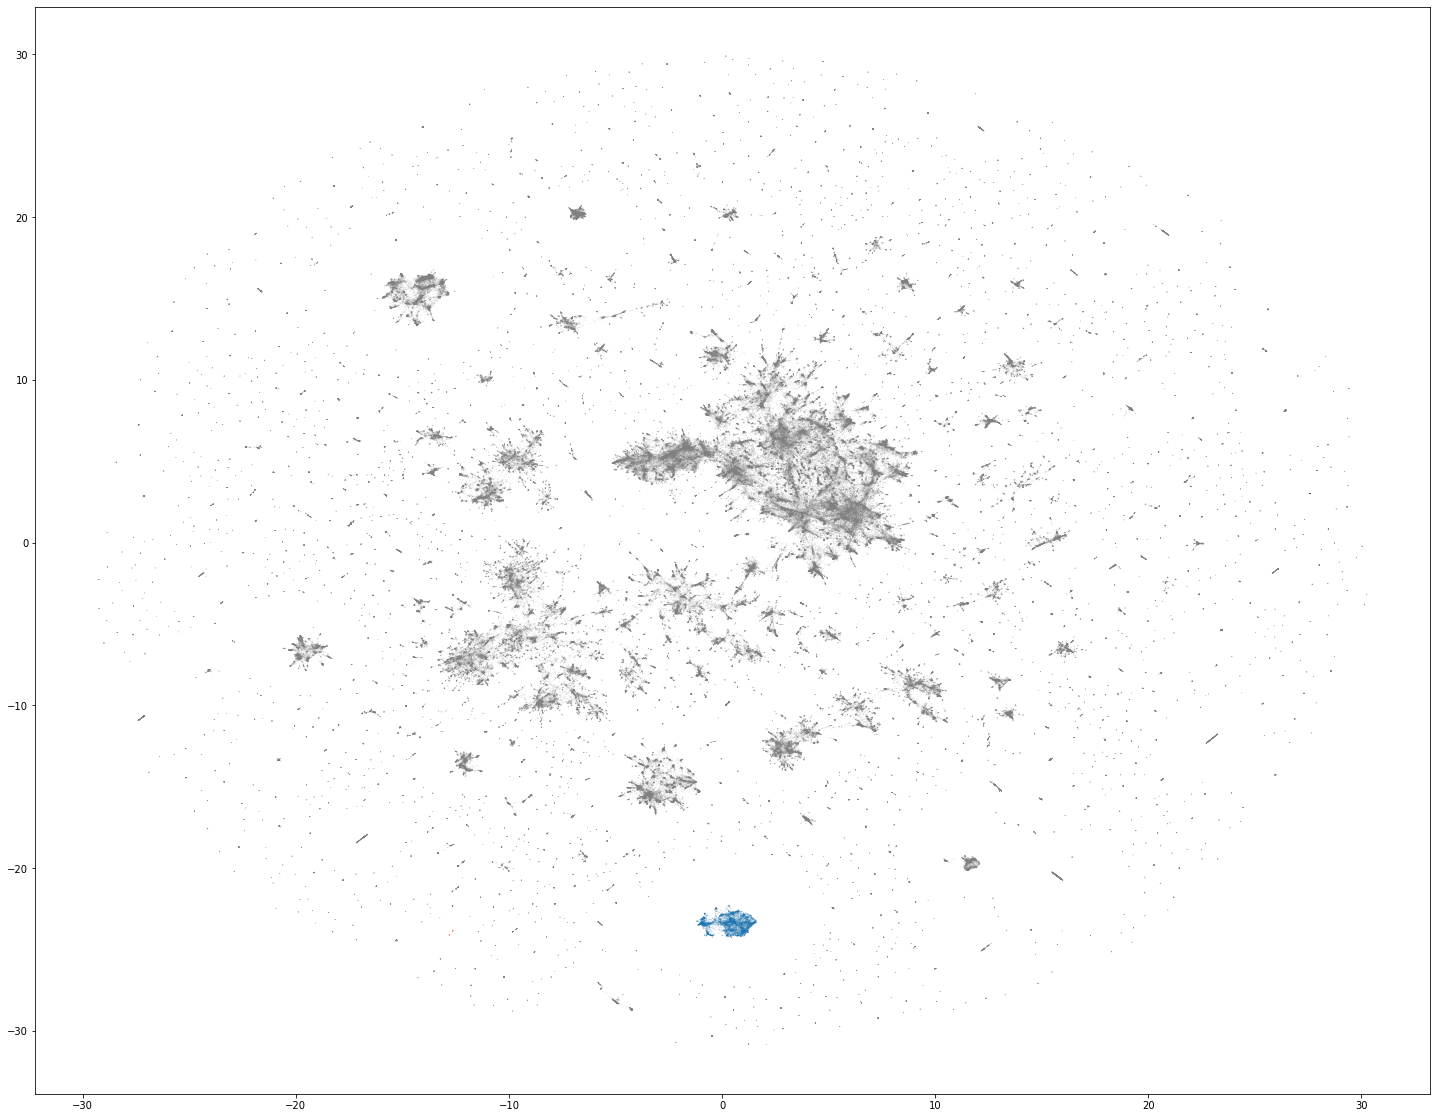

In [11]:
idxs = [1, 100, 45]

color_palette = sns.color_palette('Paired', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x in idxs
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

fig, ax = plt.subplots(figsize=(25,20))
plt.scatter(*umap_data.T, s=0.5, linewidth=0, c=cluster_member_colors, alpha=0.25)